In [1]:
import pandas as pd
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [2]:
full_data.shape

(145460, 23)

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

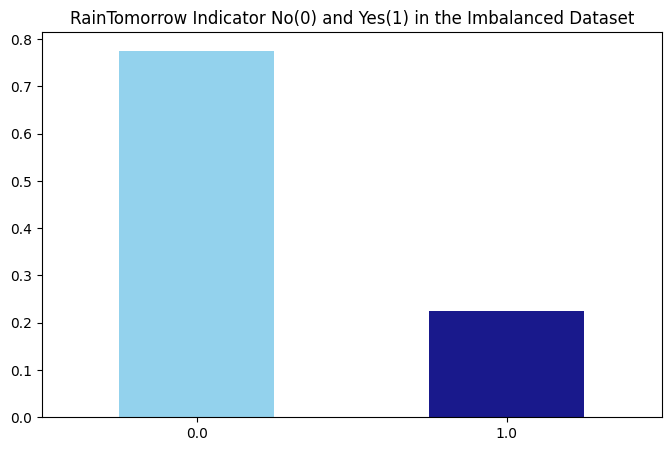

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

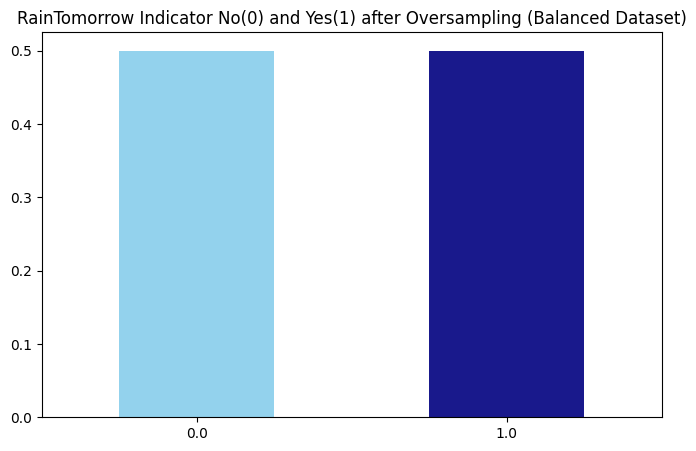

In [6]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

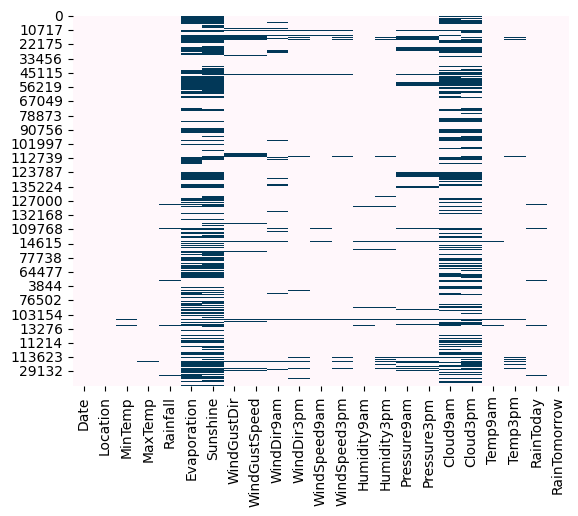

In [7]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [8]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [9]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [23]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)


In [11]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [12]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

<Axes: >

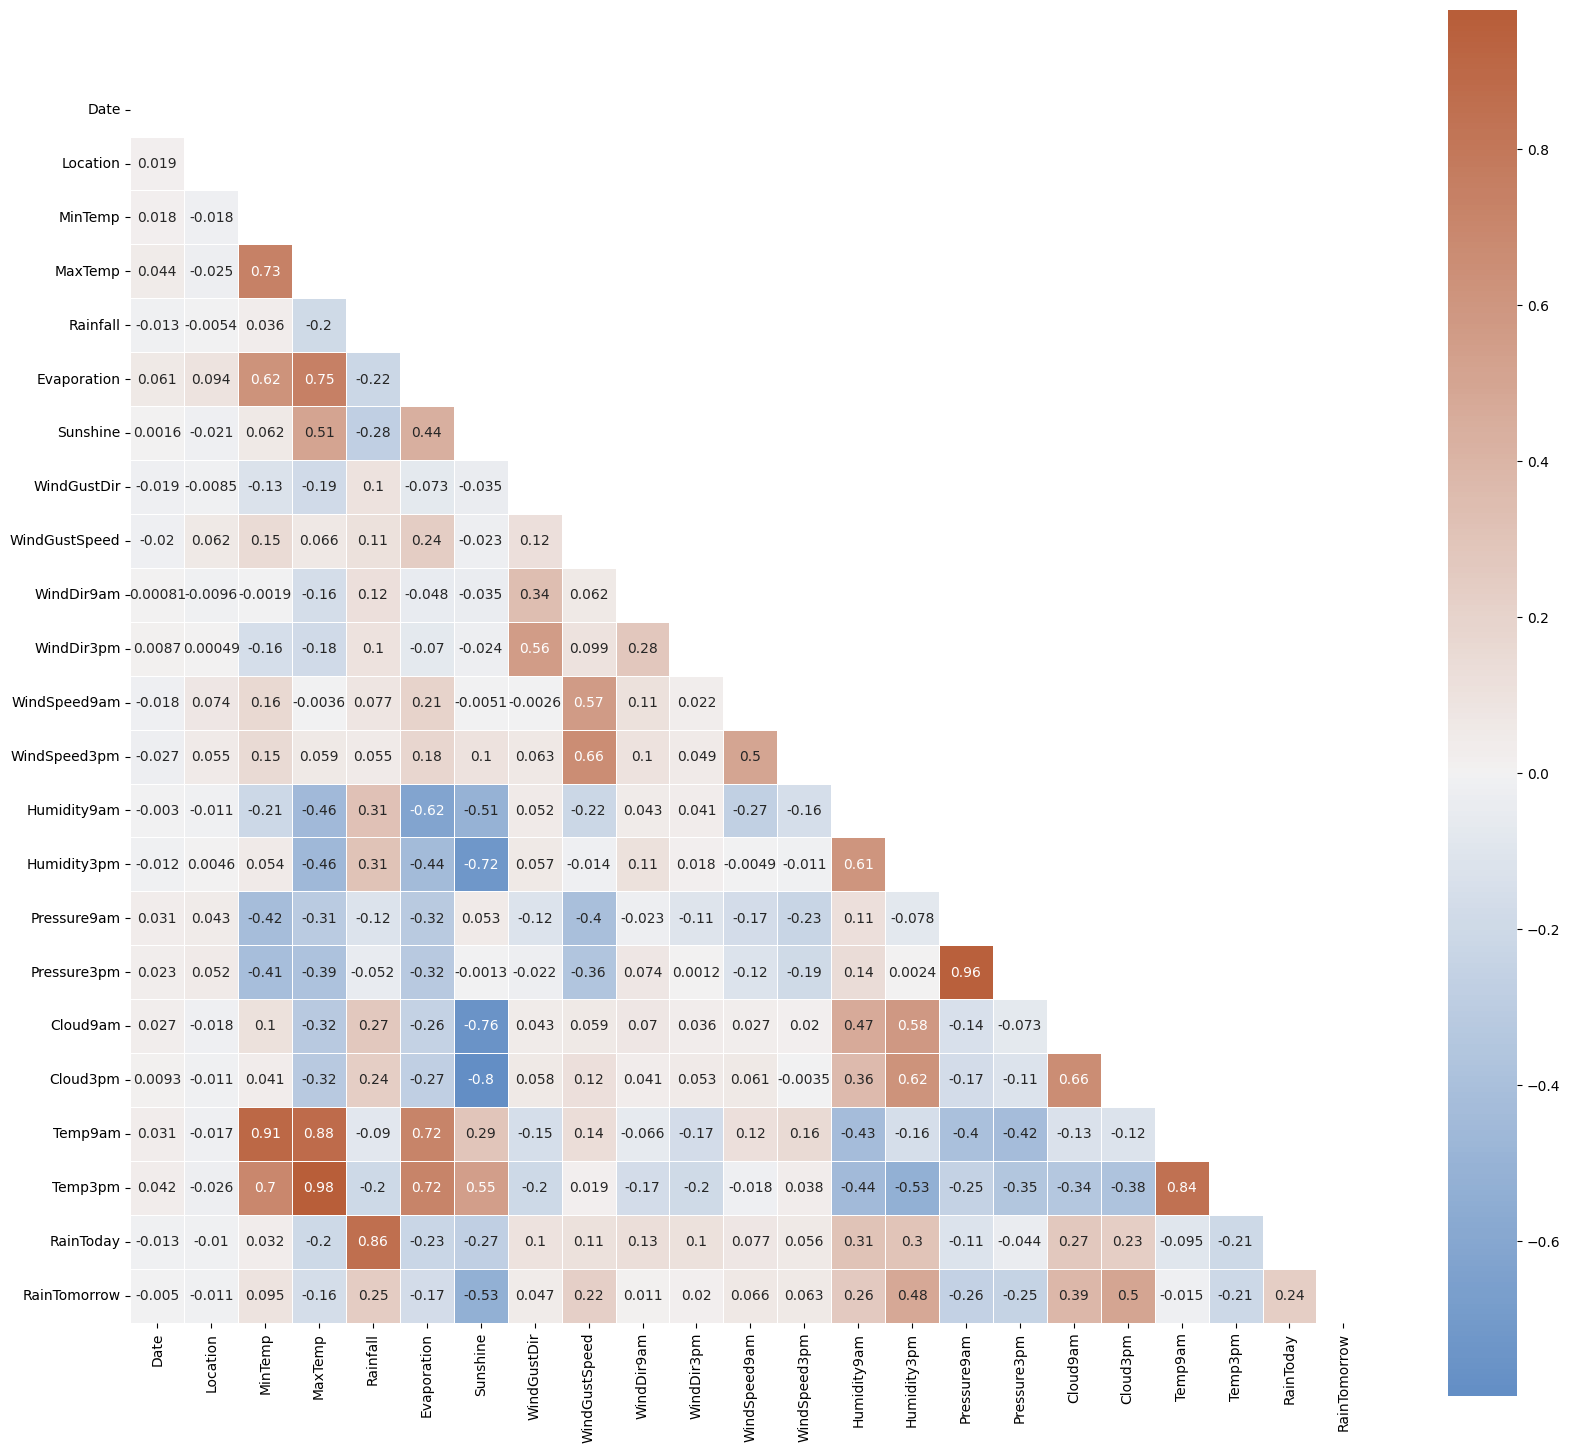

In [13]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

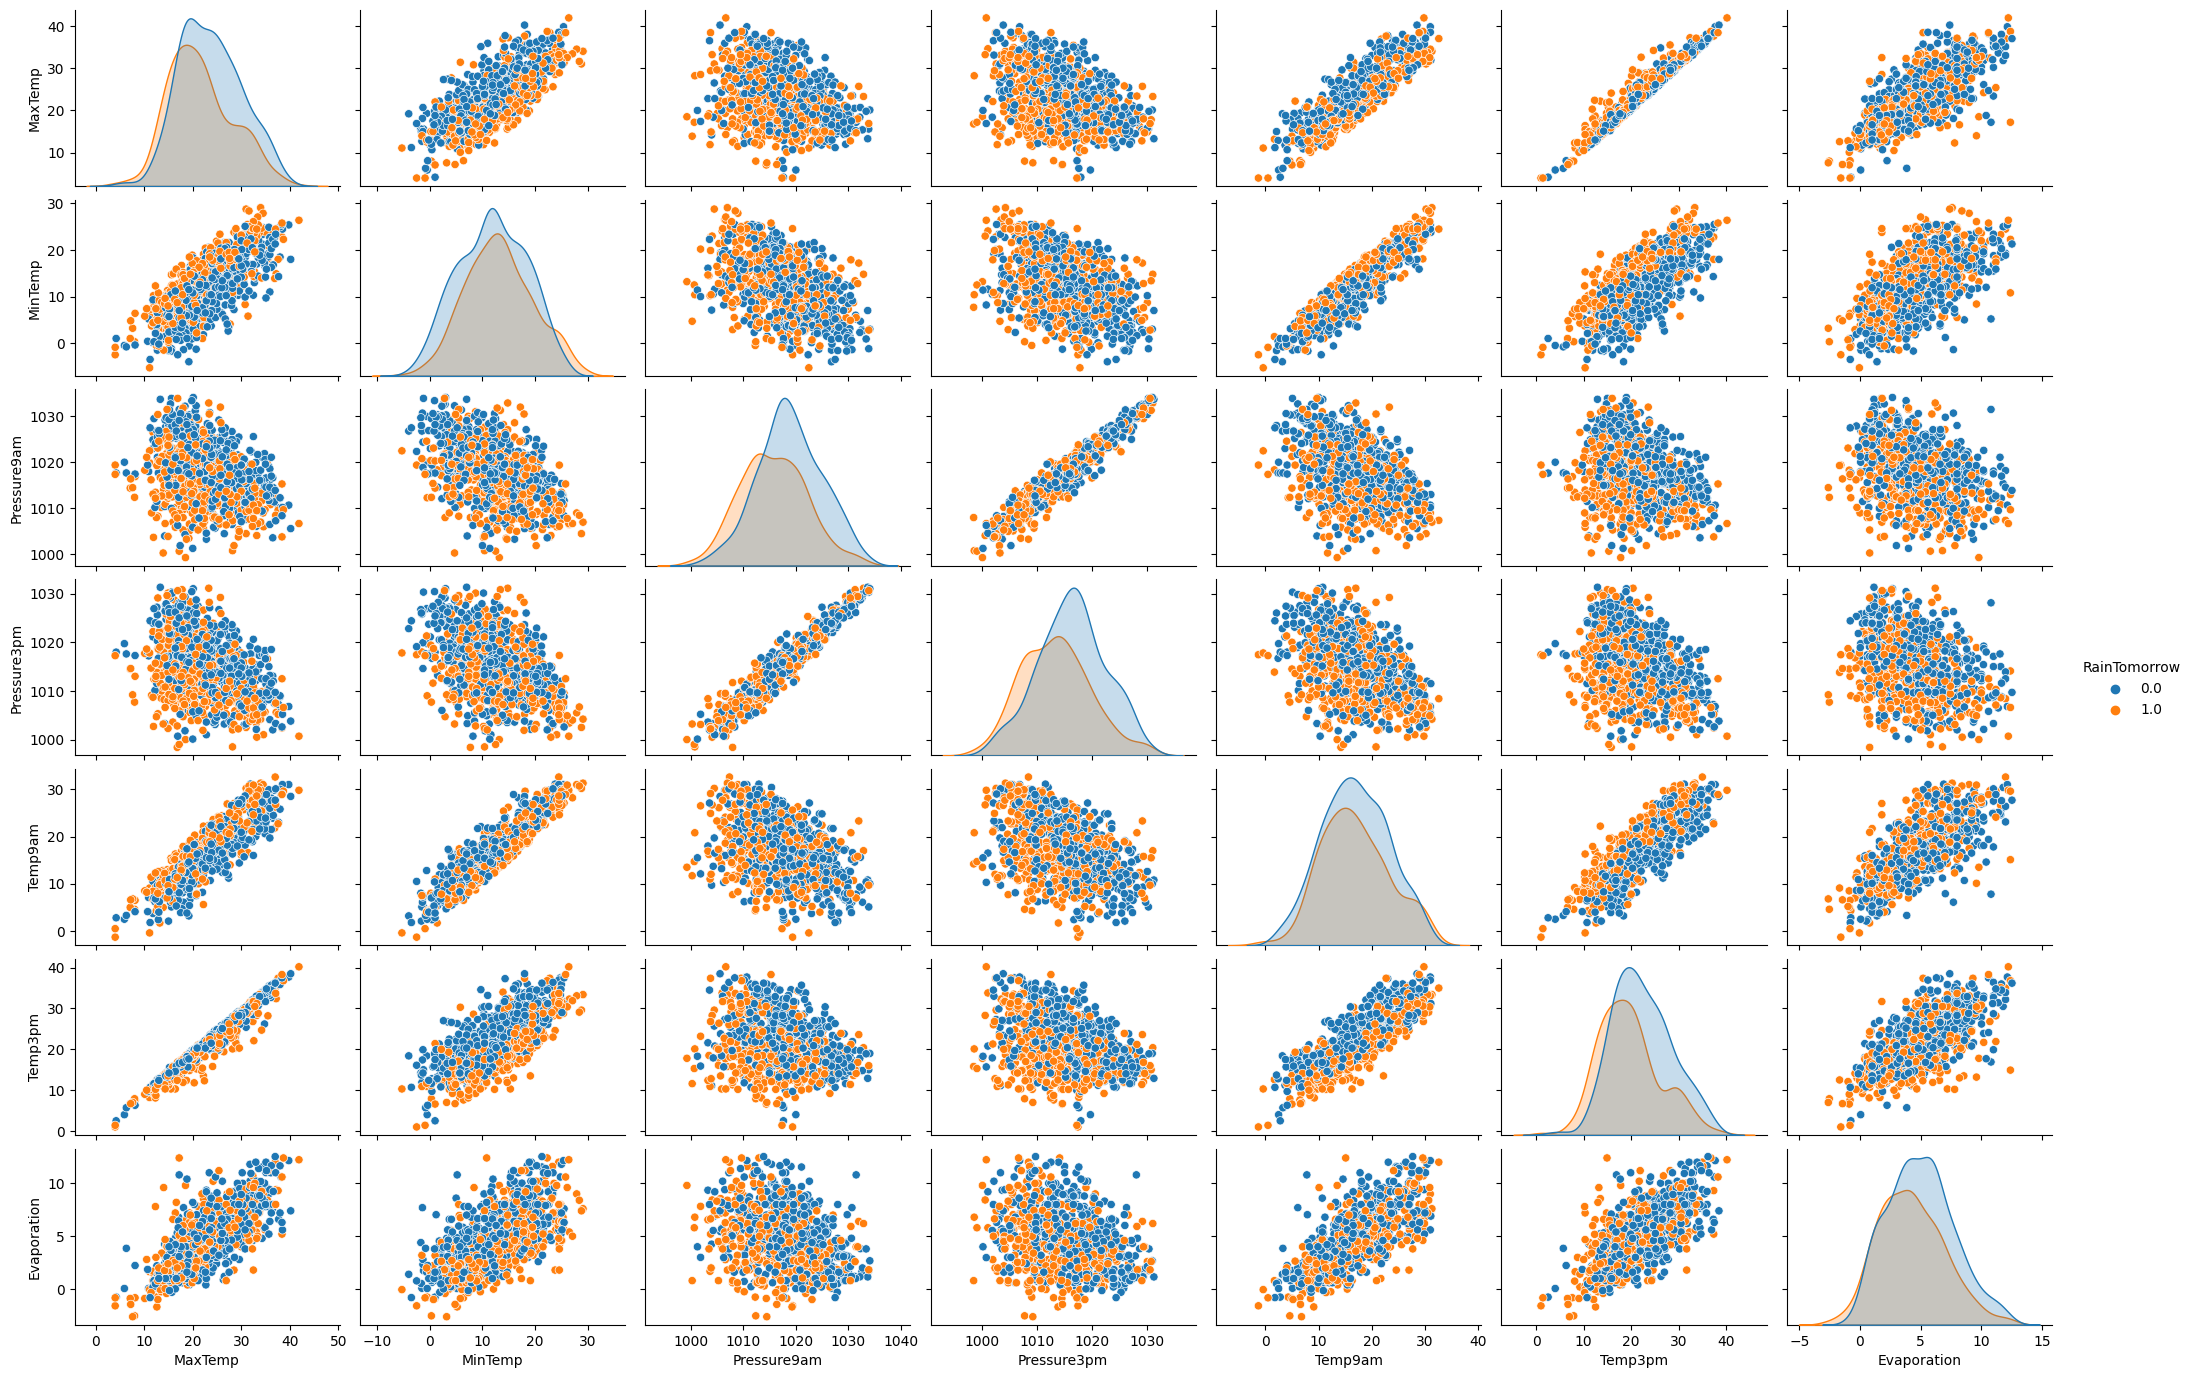

In [14]:
import seaborn as sns
import random

# Sample a subset of your data (e.g., 1000 random samples)
sampled_data = MiceImputed.sample(n=1000, random_state=42)

# Select a subset of variables
selected_vars = ('MaxTemp', 'MinTemp', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation')

# Create a pair plot with reduced data and variables
sns.pairplot(data=sampled_data, vars=selected_vars, hue='RainTomorrow', height=2, aspect=1.5)


In [15]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [16]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


In [18]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [19]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [24]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    cohen_kappa_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)

def plot_confusion_matrix_custom(model, X_test, y_test, cmap=plt.cm.Blues):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ["Class 0", "Class 1"]  # Modify class labels as needed
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test, y_pred, digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    plot_confusion_matrix_custom(model, X_test, y_test)

    return model, accuracy, roc_auc, coh_kap, time_taken


In [27]:
from sklearn.ensemble import RandomForestClassifier


In [31]:
import lightgbm as lgb


In [36]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [37]:
import catboost as cb


In [41]:
import xgboost as xgb


Accuracy = 0.7952798350051561
ROC Area under Curve = 0.7895421146723749
Cohen's Kappa = 0.5823246558119864
Time taken = 6.595012903213501
              precision    recall  f1-score   support

         0.0    0.80459   0.83764   0.82078     23879
         1.0    0.78229   0.74144   0.76132     18789

    accuracy                        0.79528     42668
   macro avg    0.79344   0.78954   0.79105     42668
weighted avg    0.79477   0.79528   0.79460     42668



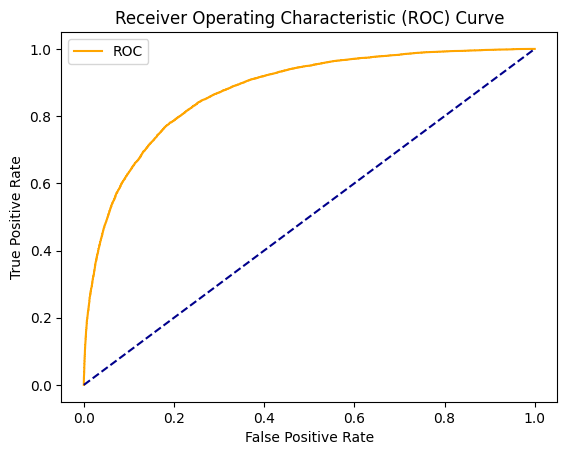

Accuracy = 0.8589575325771069
ROC Area under Curve = 0.8591166263447125
Cohen's Kappa = 0.7150936703367382
Time taken = 0.6500043869018555
              precision    recall  f1-score   support

         0.0    0.88652   0.85778   0.87191     23879
         1.0    0.82641   0.86045   0.84309     18789

    accuracy                        0.85896     42668
   macro avg    0.85646   0.85912   0.85750     42668
weighted avg    0.86005   0.85896   0.85922     42668



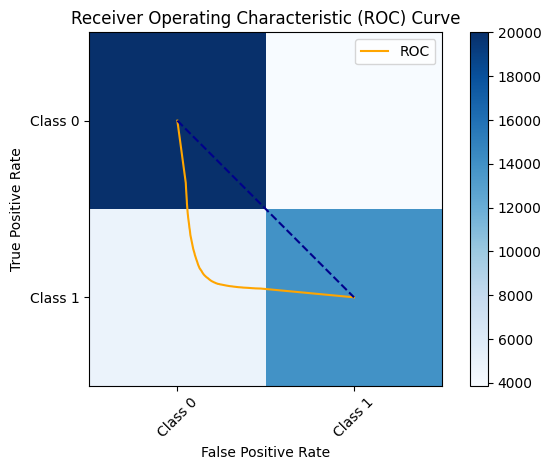

Accuracy = 0.8946048560982469
ROC Area under Curve = 0.8932960561843752
Cohen's Kappa = 0.7862576139168252
Time taken = 377.29103803634644
              precision    recall  f1-score   support

         0.0    0.90712   0.90427   0.90569     23879
         1.0    0.87882   0.88232   0.88057     18789

    accuracy                        0.89460     42668
   macro avg    0.89297   0.89330   0.89313     42668
weighted avg    0.89465   0.89460   0.89463     42668



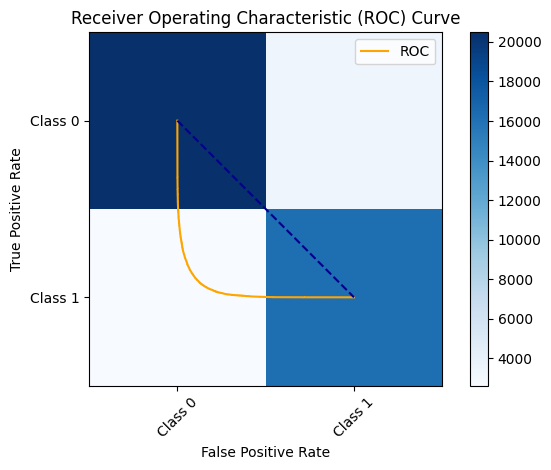

Accuracy = 0.9265960438736289
ROC Area under Curve = 0.9279584837896794
Cohen's Kappa = 0.8517906871231153
Time taken = 46.94202995300293
              precision    recall  f1-score   support

         0.0    0.95053   0.91654   0.93323     23879
         1.0    0.89854   0.93938   0.91851     18789

    accuracy                        0.92660     42668
   macro avg    0.92454   0.92796   0.92587     42668
weighted avg    0.92764   0.92660   0.92674     42668



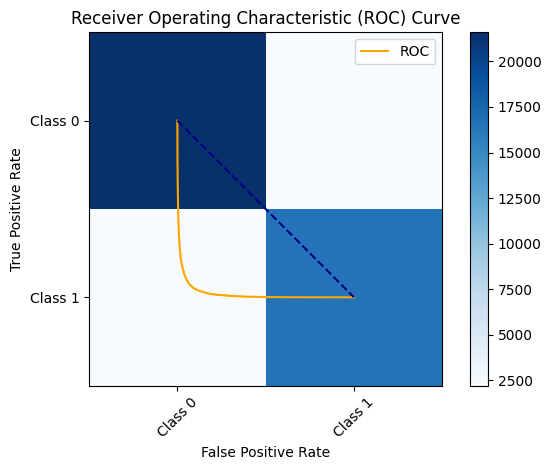

[LightGBM] [Info] Number of positive: 56230, number of negative: 71771
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4324
[LightGBM] [Info] Number of data points in the train set: 128001, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439293 -> initscore=-0.244030
[LightGBM] [Info] Start training from score -0.244030
Accuracy = 0.8661057466954157
ROC Area under Curve = 0.8637842492356467
Cohen's Kappa = 0.7281343468417281
Time taken = 7.602621555328369
              precision    recall  f1-score   support

         0.0    0.87821   0.88324   0.88072     23879
         1.0    0.85053   0.84432   0.84741     18789

    accuracy                        0.86611     42668
   macro avg    0.86437   0.86378   0.86407     42668
weighted avg    0.86602   0.86611   0.86605     42668



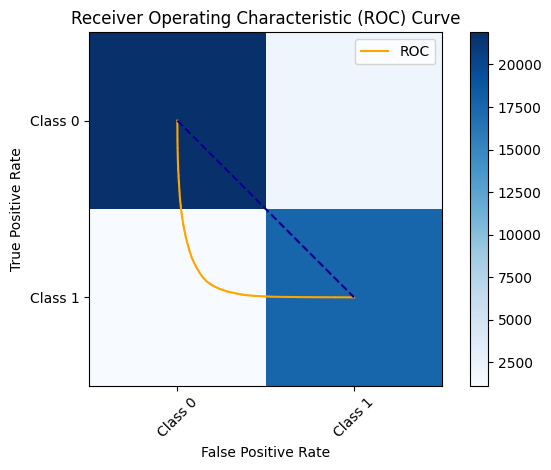

Accuracy = 0.9392050248429736
ROC Area under Curve = 0.9424115092864753
Cohen's Kappa = 0.8776540964755455
Time taken = 400.8085882663727
              precision    recall  f1-score   support

         0.0    0.97429   0.91553   0.94400     23879
         1.0    0.90029   0.96929   0.93352     18789

    accuracy                        0.93921     42668
   macro avg    0.93729   0.94241   0.93876     42668
weighted avg    0.94170   0.93921   0.93938     42668



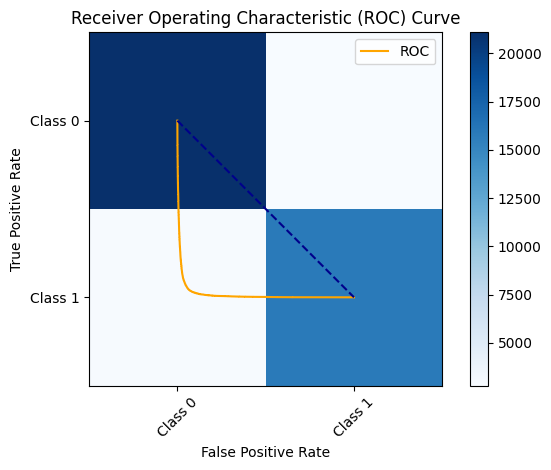

Accuracy = 0.9333458329427206
ROC Area under Curve = 0.9378631464101468
Cohen's Kappa = 0.866233152337708
Time taken = 24.629186630249023
              precision    recall  f1-score   support

         0.0    0.97922   0.90000   0.93794     23879
         1.0    0.88475   0.97573   0.92802     18789

    accuracy                        0.93335     42668
   macro avg    0.93199   0.93786   0.93298     42668
weighted avg    0.93762   0.93335   0.93357     42668



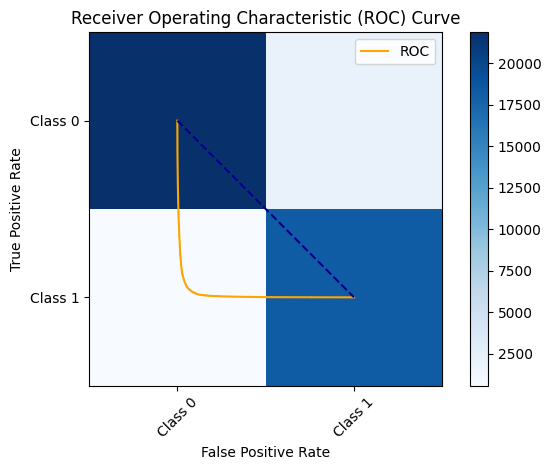

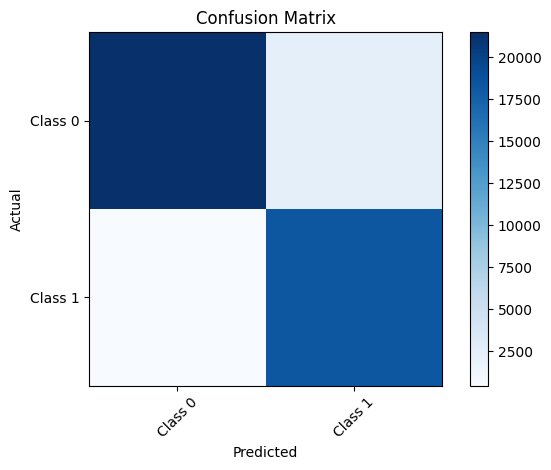

In [49]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95,
         'max_depth': 16,
         'min_split_gain': 0.1,
         'n_estimators': 200,
         'num_leaves': 50,
         'reg_alpha': 1.2,
         'reg_lambda': 1.2,
         'subsample': 0.95,
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# Suppress LightGBM warning
lgb_params = {'force_col_wise': True}
lgb_classifier = lgb.LGBMClassifier(random_state=12345, verbose=0, **lgb_params)

# Define classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=12345)),
    ('Decision Tree', DecisionTreeClassifier(random_state=12345)),
    ('Neural Network', MLPClassifier(random_state=12345, verbose=0)),
    ('Random Forest', RandomForestClassifier(random_state=12345)),
    ('LightGBM', lgb_classifier),  # Use the modified LightGBM classifier here
    ('CatBoost', cb.CatBoostClassifier(random_state=12345, verbose=0)),
    ('XGBoost', xgb.XGBClassifier(random_state=12345)),
]

# Create an Ensemble classifier
eclf = EnsembleVoteClassifier(clfs=[clf[1] for clf in classifiers], weights=[1] * len(classifiers), voting='soft')

# Define features and labels
X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]]
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(18, 14))



<Figure size 1800x1400 with 0 Axes>

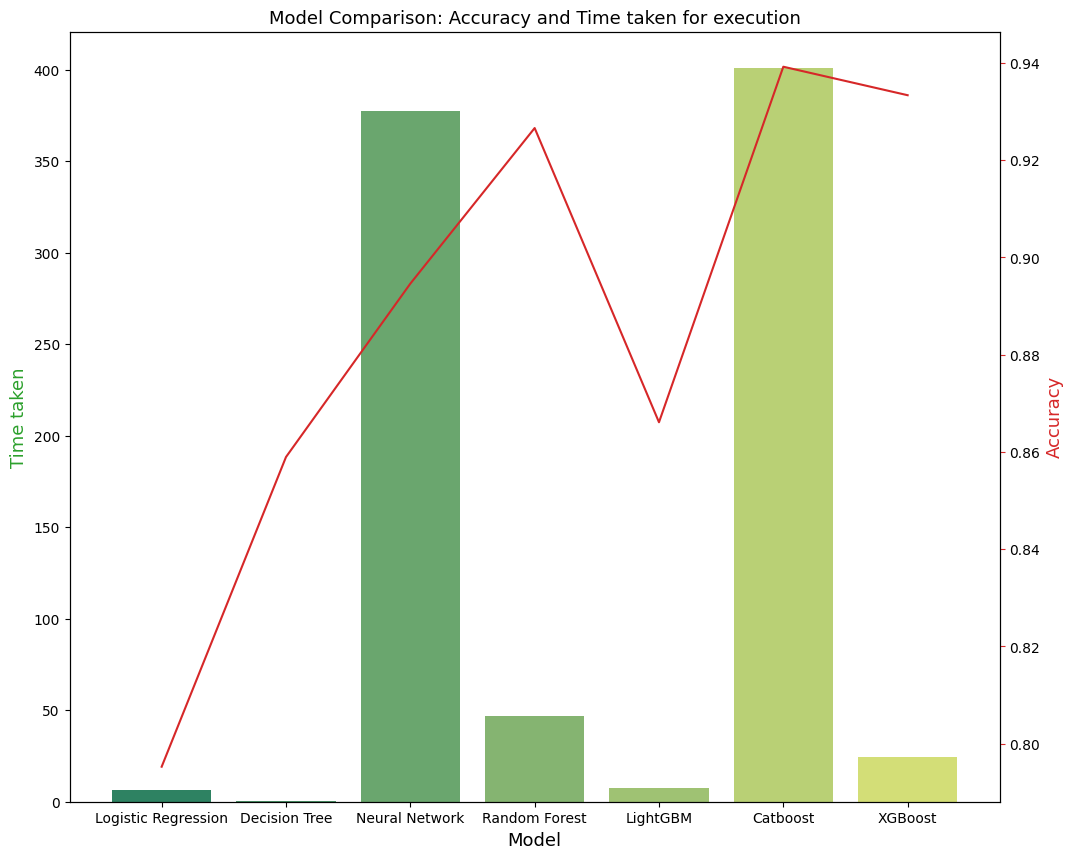

In [58]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

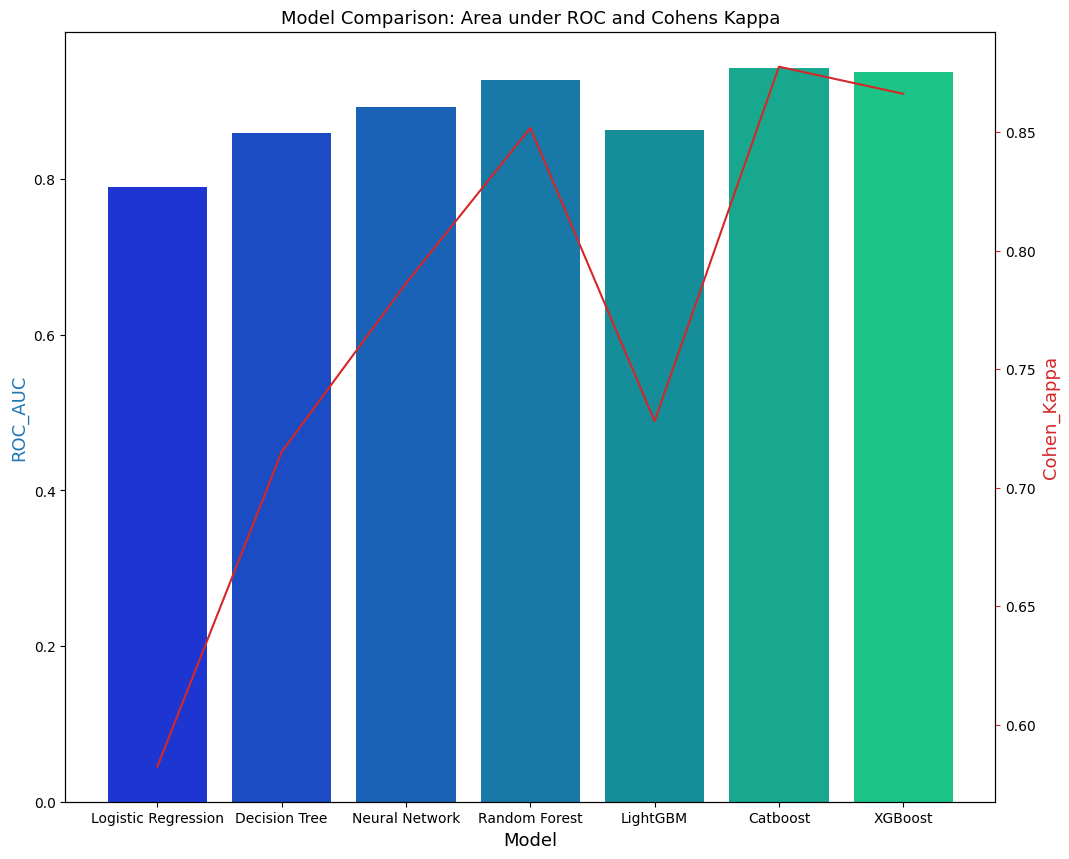

In [59]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()